In [9]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [10]:
# The unit of the metric from the knative dashboard is falsely labeled as seconds. It is actually in the used CPU cores.
def to_used_cpu_cores(val):
    if pd.isna(val):
        return None
    val = str(val).strip().lower()

    if val.endswith("ms"):
        return float(val.replace("ms", "").strip()) / 1000.0
    elif val.endswith("µs") or val.endswith("us"):  # handle µs or us
        return float(val.replace("µs", "").replace("us", "").strip()) / 1_000_000.0
    elif val.endswith("s"):
        return float(val.replace("s", "").strip())
    else:
        # assume it's already s
        return float(val)


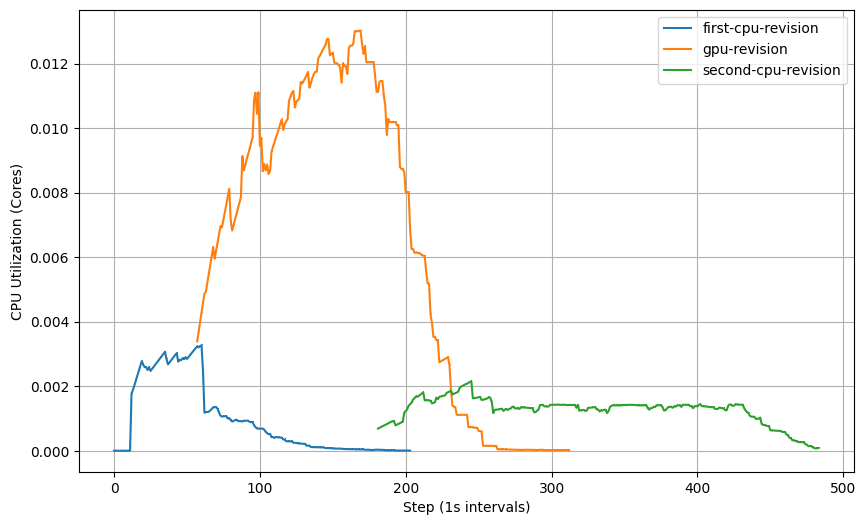

In [11]:
# CPU Utilization Auto

# Load all CSV files
# Load CSVs
csv_files_auto_cpu = glob.glob("./data/auto/*resources.csv")

dfs_auto_cpu = []
for file in csv_files_auto_cpu:
    df = pd.read_csv(file, usecols=["cpu-cpu-1_user-container", "cpu-gpu_user-container", "cpu-cpu-2_user-container"])
    df["cpu-cpu-1_user-container"] = df["cpu-cpu-1_user-container"].apply(to_used_cpu_cores)
    df["cpu-gpu_user-container"] = df["cpu-gpu_user-container"].apply(to_used_cpu_cores)
    df["cpu-cpu-2_user-container"] = df["cpu-cpu-2_user-container"].apply(to_used_cpu_cores)
    dfs_auto_cpu.append(df)

# Combine into one DataFrame
combined_auto = pd.concat(dfs_auto_cpu, axis=1)

means_auto_cpu_container_1 = combined_auto["cpu-cpu-1_user-container"].mean(axis=1)
means_auto_gpu_container = combined_auto["cpu-gpu_user-container"].mean(axis=1)
means_auto_cpu_container_2 = combined_auto["cpu-cpu-2_user-container"].mean(axis=1)

plt.figure(figsize=(10,6))

plt.plot(means_auto_cpu_container_1.index, means_auto_cpu_container_1, marker=",", label="first-cpu-revision")
plt.plot(means_auto_gpu_container.index, means_auto_gpu_container, marker=",", label="gpu-revision")
plt.plot(means_auto_cpu_container_2.index, means_auto_cpu_container_2, marker=",", label="second-cpu-revision")

plt.xlabel("Step (1s intervals)")
plt.ylabel("CPU Utilization (Cores)")
plt.legend()
plt.grid(True)
plt.show()



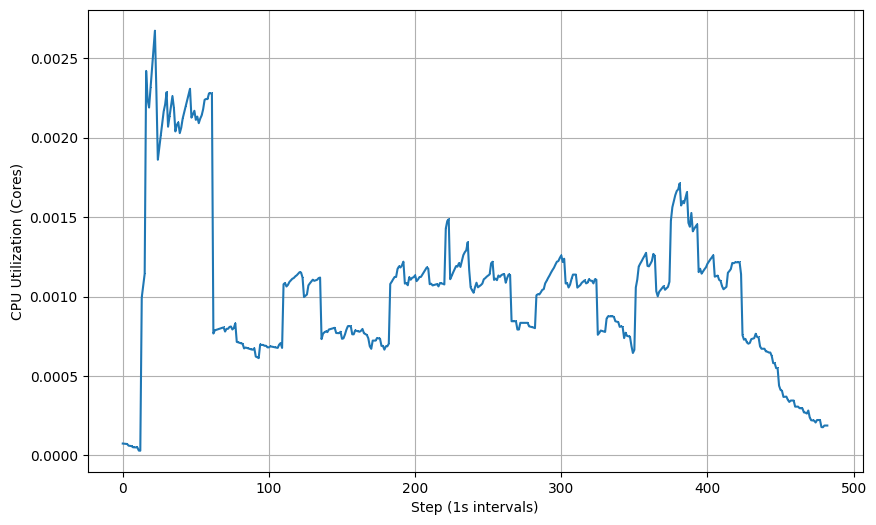

In [12]:
# CPU Utilization CPU mode

# Load all CSV files
csv_files_cpu = glob.glob("./data/cpu/*resources.csv")

# clean
dfs_cpu = []
for file in csv_files_cpu:
    df = pd.read_csv(file, usecols=["cpu_user-container"])
    df["cpu_user-container"] = df["cpu_user-container"].apply(to_used_cpu_cores)
    dfs_cpu.append(df)


combined_cpu = pd.concat(dfs_cpu, axis=1)
combined_cpu.fillna(0)

means_cpu = combined_cpu.mean(axis=1)

plt.figure(figsize=(10,6))

plt.plot(means_cpu.index, means_cpu, marker=",")

plt.xlabel("Step (1s intervals)")
plt.ylabel("CPU Utilization (Cores)")
# plt.legend()
plt.grid(True)
plt.show()

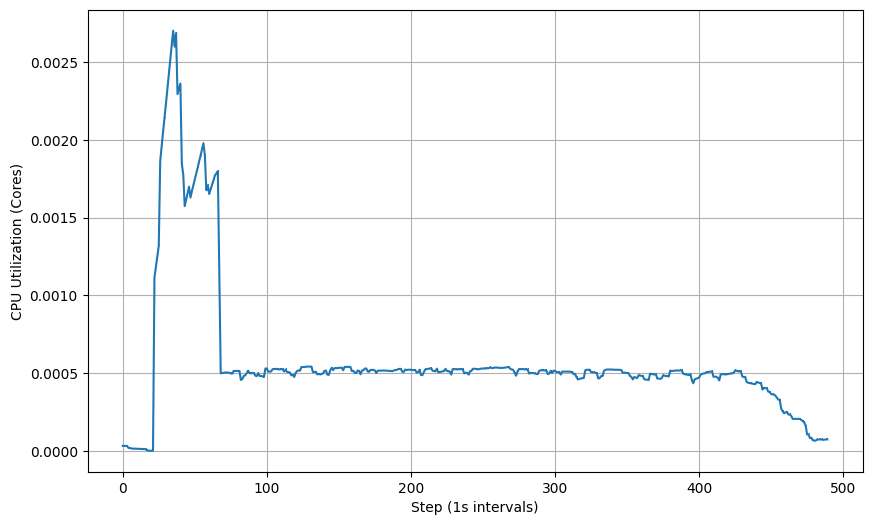

In [13]:
# CPU Utilization GPU mode

# Load all CSV files
csv_files_gpu = glob.glob("./data/gpu/*resources.csv")

# clean
dfs_gpu = []
for file in csv_files_gpu:
    df = pd.read_csv(file, usecols=["cpu_user-container"])
    df["cpu_user-container"] = df["cpu_user-container"].apply(to_used_cpu_cores)
    dfs_gpu.append(df)


combined_gpu = pd.concat(dfs_gpu, axis=1)
combined_gpu.fillna(0)

means_gpu = combined_gpu.mean(axis=1)

pd.set_option('display.max_rows', None)

plt.figure(figsize=(10,6))

# only between index 200 and 400
# means_cpu = means_cpu[25:75]

plt.plot(means_gpu.index, means_gpu, marker=",")

plt.xlabel("Step (1s intervals)")
plt.ylabel("CPU Utilization (Cores)")
# plt.legend()
plt.grid(True)
plt.show()

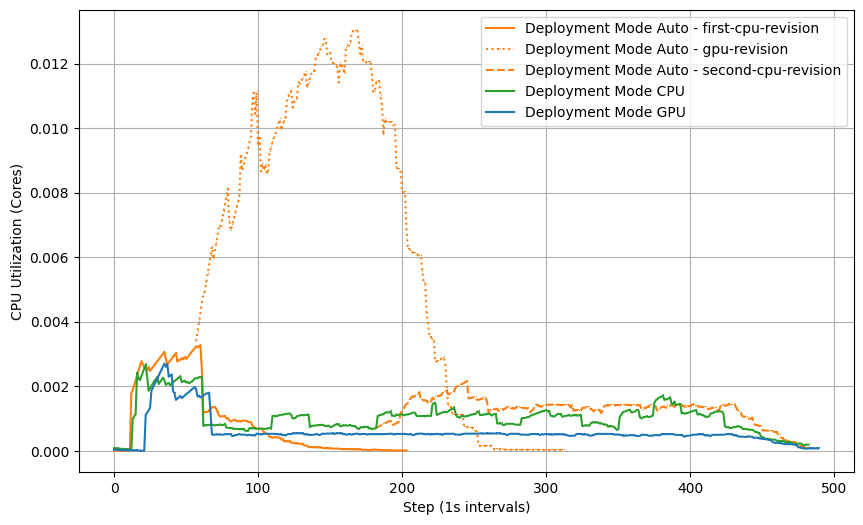

In [20]:
plt.figure(figsize=(10,6))

line1, = plt.plot(means_auto_cpu_container_1.index, means_auto_cpu_container_1,
                  marker=",", label="Deployment Mode Auto - first-cpu-revision", color="tab:orange")
plt.plot(means_auto_gpu_container.index, means_auto_gpu_container,
         marker=",", linestyle=":", color=line1.get_color(),
         label="Deployment Mode Auto - gpu-revision")
plt.plot(means_auto_cpu_container_2.index, means_auto_cpu_container_2,
         marker=",", linestyle="--", color=line1.get_color(),
         label="Deployment Mode Auto - second-cpu-revision")

plt.plot(means_cpu.index, means_cpu, marker=",", label="Deployment Mode CPU", color="tab:green")

plt.plot(means_gpu.index, means_gpu, marker=",", label="Deployment Mode GPU", color="tab:blue")



plt.xlabel("Step (1s intervals)")
plt.ylabel("CPU Utilization (Cores)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Export to csv

df_lines = pd.DataFrame({
    "AUTO-first-cpu-revision": means_auto_cpu_container_1,
    "AUTO-gpu-revision": means_auto_gpu_container,
    "AUTO-second-cpu-revision": means_auto_cpu_container_2,
    "CPU": means_cpu,
    "GPU": means_gpu
})

# Save to CSV
df_lines.to_csv("cpu.csv", index_label="Index")



In [16]:
# Get cost rates

cpu_rate = 0.000034  # per second per vCPU

mean_cpu_cpu = means_cpu.mean()  # since auto mode is always on CPU
mean_cpu_gpu = means_gpu.mean()

print(f"Mean CPU Cpu: {mean_cpu_cpu}")
print(f"Mean CPU GPU: {mean_cpu_gpu}")

cost_cpu = mean_cpu_cpu * cpu_rate
cost_gpu = mean_cpu_gpu * cpu_rate
print(f"Estimated cost per second in CPU mode: ${cost_cpu:.8f}")
print(f"Estimated cost per second in GPU mode: ${cost_gpu:.8f}")

Mean CPU Cpu: 0.0010309176501035195
Mean CPU GPU: 0.0005848741139455782
Estimated cost per second in CPU mode: $0.00000004
Estimated cost per second in GPU mode: $0.00000002
